# BipedalWalker-v2 with A2C, Vectorized Environment
In this notebook, you will implement a PPO agent with OpenAI Gym's BipedalWalker-v2 environment.

### 1. Create Vectorized Environment

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from  collections  import deque
import time
from model import Policy

from a2c_RMSprop import a2c_agent 
from storage import RolloutStorage
from utils import get_render_func, get_vec_normalize

from parallelEnv import parallelEnv
import matplotlib.pyplot as plt
%matplotlib inline

print('gym version: ', gym.__version__)
print('torch version: ', torch.__version__)

seed = 0 
gamma=0.99
num_processes=16 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

envs = parallelEnv('BipedalWalker-v2', n=num_processes, seed=seed)

## make_vec_envs -cannot find context for 'forkserver'
## forkserver is only available in Python 3.4+ and only on some Unix platforms (not on Windows).
## envs = make_vec_envs('BipedalWalker-v2', \
##                    seed + 1000, num_processes,
##                    None, None, False, device='cpu', allow_early_resets=False)

max_steps = envs.max_steps
print('max_steps: ', max_steps)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)


gym version:  0.13.1
torch version:  1.0.1
device:  cuda:0
max_steps:  1600


### 2. Instantiate Model, Agent and Storage

Initialize the Policy (model MLPBase), PPO Agent and Rollout Storage.

In [2]:
## model Policy uses MLPBase
policy = Policy(envs.observation_space.shape, envs.action_space,\
        base_kwargs={'recurrent': False})

policy.to(device)

## optim.RMSprop, lr = 0.001
agent = a2c_agent(actor_critic=policy, value_loss_coef=0.5,entropy_coef=0.01,\
            lr=0.001, eps=1e-5, alpha=0.99, max_grad_norm=0.5)

rollouts = RolloutStorage(num_steps=max_steps, num_processes=num_processes, \
                        obs_shape=envs.observation_space.shape, action_space=envs.action_space, \
                        recurrent_hidden_state_size=policy.recurrent_hidden_state_size)

obs = envs.reset()
print('type obs: ', type(obs), ', shape obs: ', obs.shape)
obs_t = torch.tensor(obs)
print('type obs_t: ', type(obs_t), ', shape obs_t: ', obs_t.shape)

rollouts.obs[0].copy_(obs_t)
rollouts.to(device)


type obs:  <class 'numpy.ndarray'> , shape obs:  (16, 24)
type obs_t:  <class 'torch.Tensor'> , shape obs_t:  torch.Size([16, 24])


### 3.Save model function

In [3]:
def save(model, directory, filename, suffix):
    torch.save(model.base.actor.state_dict(), '%s/%s_actor_%s.pth' % (directory, filename, suffix))
    torch.save(model.base.critic.state_dict(), '%s/%s_critic_%s.pth' % (directory, filename, suffix))
    torch.save(model.base.critic_linear.state_dict(), '%s/%s_critic_linear_%s.pth' % (directory, filename, suffix))
    
limits = [-300, -160, -100, -70, -50, 0, 20, 30, 40, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits)-1):
        if j > limits[i] and j < limits[i+1]:
            suf = str(limits[i+1])
            break
        
        i_last = len(limits)-1    
        if  j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf      

### 4. Train the Agent  with Vectorized Environment

In [4]:
num_updates=1000000
gamma = 0.99
tau=0.95
save_interval=30
log_interval= 1 

def a2c_vec_env_train(envs, agent, policy, num_processes, num_steps, rollouts):
    
    time_start = time.time()
    
    n=len(envs.ps)    
    envs.reset()
    
    # start all parallel agents
    print('Number of agents: ', n)
    envs.step([[1]*4]*n)
    
    indices = []
    for i  in range(n):
        indices.append(i)
     
    s = 0
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    for i_episode in range(num_updates):
        
        total_reward = np.zeros(n)
        timestep = 0
        
        for timestep in range(num_steps):

            with torch.no_grad():
                value, actions, action_log_prob, recurrent_hidden_states = \
                   policy.act(
                        rollouts.obs[timestep],
                        rollouts.recurrent_hidden_states[timestep],
                        rollouts.masks[timestep])
                
            obs, rewards, done, infos = envs.step(actions.cpu().detach().numpy())
            
            total_reward += rewards  ## this is the list by agents
                        
            # If done then clean the history of observations.
            masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
            obs_t = torch.tensor(obs)
            ## Add one dimnesion to tensor, otherwise does not work
            ## This is (unsqueeze(1)) solution for:
            ## RuntimeError: The expanded size of the tensor (1) must match the existing size...
            rewards_t = torch.tensor(rewards).unsqueeze(1)
            rollouts.insert(obs_t, recurrent_hidden_states, actions, action_log_prob, \
                value, rewards_t, masks)
                    
        avg_total_reward = np.mean(total_reward)
        scores_deque.append(avg_total_reward)
        scores_array.append(avg_total_reward)
                
        with torch.no_grad():
            next_value = policy.get_value(rollouts.obs[-1],
                            rollouts.recurrent_hidden_states[-1],
                            rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, gamma, tau)

        agent.update(rollouts)

        rollouts.after_update()
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        if i_episode > 0 and i_episode % save_interval == 0:
            print('Saving model, i_episode: ', i_episode, '\n')
            suf = return_suffix(avg_score)
            save(policy, 'dir_chk_RMSprop', 'weights_a2c', suf)
            #save_venv(policy, 'dir_save_VecEnv', 'final')

        
        if i_episode % log_interval == 0 and len(scores_deque) > 1:            
            prev_s = s
            s = (int)(time.time() - time_start)
            t_del = s - prev_s
            print('Ep. {}, Timesteps {}, Score.Agents: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}, \
Interval: {:02}:{:02}'\
                   .format(i_episode, timestep+1, \
                        avg_total_reward, avg_score, s//3600, s%3600//60, s%60, t_del%3600//60, t_del%60)) 
    
        if len(scores_deque) == 100 and np.mean(scores_deque) > 300.5:   
            print('Environment solved with Average Score: ',  np.mean(scores_deque) )
            break
    
    
    return scores_array, avg_scores_array
            

In [5]:
scores, avg_scores = a2c_vec_env_train(envs, agent, policy, num_processes, max_steps, rollouts)


Number of agents:  16
Ep. 1, Timesteps 1600, Score.Agents: -488.22, Avg.Score: -768.38, Time: 00:01:06, Interval: 01:06
Ep. 2, Timesteps 1600, Score.Agents: -465.31, Avg.Score: -667.36, Time: 00:01:37, Interval: 00:31
Ep. 3, Timesteps 1600, Score.Agents: -160.44, Avg.Score: -540.63, Time: 00:02:07, Interval: 00:30
Ep. 4, Timesteps 1600, Score.Agents: -2089.90, Avg.Score: -850.48, Time: 00:02:36, Interval: 00:29
Ep. 5, Timesteps 1600, Score.Agents: -2340.25, Avg.Score: -1098.78, Time: 00:03:05, Interval: 00:29
Ep. 6, Timesteps 1600, Score.Agents: -2373.69, Avg.Score: -1280.91, Time: 00:03:36, Interval: 00:31
Ep. 7, Timesteps 1600, Score.Agents: -2304.94, Avg.Score: -1408.91, Time: 00:04:06, Interval: 00:30
Ep. 8, Timesteps 1600, Score.Agents: -2239.26, Avg.Score: -1501.17, Time: 00:04:34, Interval: 00:28
Ep. 9, Timesteps 1600, Score.Agents: -1973.49, Avg.Score: -1548.40, Time: 00:05:05, Interval: 00:31
Ep. 10, Timesteps 1600, Score.Agents: -1203.35, Avg.Score: -1517.04, Time: 00:05:35, 

Ep. 83, Timesteps 1600, Score.Agents: -100.55, Avg.Score: -353.20, Time: 00:41:10, Interval: 00:29
Ep. 84, Timesteps 1600, Score.Agents: -106.71, Avg.Score: -350.30, Time: 00:41:38, Interval: 00:28
Ep. 85, Timesteps 1600, Score.Agents: -90.95, Avg.Score: -347.28, Time: 00:42:06, Interval: 00:28
Ep. 86, Timesteps 1600, Score.Agents: -87.77, Avg.Score: -344.30, Time: 00:42:34, Interval: 00:28
Ep. 87, Timesteps 1600, Score.Agents: -138.96, Avg.Score: -341.97, Time: 00:43:02, Interval: 00:28
Ep. 88, Timesteps 1600, Score.Agents: -89.21, Avg.Score: -339.13, Time: 00:43:30, Interval: 00:28
Ep. 89, Timesteps 1600, Score.Agents: -123.55, Avg.Score: -336.73, Time: 00:43:58, Interval: 00:28
Saving model, i_episode:  90 

Ep. 90, Timesteps 1600, Score.Agents: -79.91, Avg.Score: -333.91, Time: 00:44:25, Interval: 00:27
Ep. 91, Timesteps 1600, Score.Agents: -117.88, Avg.Score: -331.56, Time: 00:44:53, Interval: 00:28
Ep. 92, Timesteps 1600, Score.Agents: -100.96, Avg.Score: -329.08, Time: 00:45:21,

Ep. 165, Timesteps 1600, Score.Agents: -94.63, Avg.Score: -121.96, Time: 01:19:10, Interval: 00:28
Ep. 166, Timesteps 1600, Score.Agents: -81.96, Avg.Score: -121.40, Time: 01:19:38, Interval: 00:28
Ep. 167, Timesteps 1600, Score.Agents: -80.08, Avg.Score: -121.35, Time: 01:20:06, Interval: 00:28
Ep. 168, Timesteps 1600, Score.Agents: -84.43, Avg.Score: -121.44, Time: 01:20:34, Interval: 00:28
Ep. 169, Timesteps 1600, Score.Agents: -121.82, Avg.Score: -121.66, Time: 01:21:02, Interval: 00:28
Ep. 170, Timesteps 1600, Score.Agents: -97.07, Avg.Score: -121.02, Time: 01:21:30, Interval: 00:28
Ep. 171, Timesteps 1600, Score.Agents: -81.31, Avg.Score: -120.35, Time: 01:21:58, Interval: 00:28
Ep. 172, Timesteps 1600, Score.Agents: -94.62, Avg.Score: -120.20, Time: 01:22:25, Interval: 00:27
Ep. 173, Timesteps 1600, Score.Agents: -96.96, Avg.Score: -120.16, Time: 01:22:53, Interval: 00:28
Ep. 174, Timesteps 1600, Score.Agents: -89.94, Avg.Score: -117.36, Time: 01:23:21, Interval: 00:28
Ep. 175, 

Ep. 247, Timesteps 1600, Score.Agents: -61.09, Avg.Score: -107.18, Time: 01:57:13, Interval: 00:27
Ep. 248, Timesteps 1600, Score.Agents: -118.87, Avg.Score: -107.72, Time: 01:57:41, Interval: 00:28
Ep. 249, Timesteps 1600, Score.Agents: -89.65, Avg.Score: -107.57, Time: 01:58:09, Interval: 00:28
Ep. 250, Timesteps 1600, Score.Agents: -46.91, Avg.Score: -107.37, Time: 01:58:37, Interval: 00:28
Ep. 251, Timesteps 1600, Score.Agents: -58.20, Avg.Score: -107.30, Time: 01:59:05, Interval: 00:28
Ep. 252, Timesteps 1600, Score.Agents: -109.40, Avg.Score: -107.26, Time: 01:59:33, Interval: 00:28
Ep. 253, Timesteps 1600, Score.Agents: -79.43, Avg.Score: -106.85, Time: 02:00:00, Interval: 00:27
Ep. 254, Timesteps 1600, Score.Agents: -58.96, Avg.Score: -106.29, Time: 02:00:28, Interval: 00:28
Ep. 255, Timesteps 1600, Score.Agents: -67.70, Avg.Score: -106.17, Time: 02:00:56, Interval: 00:28
Ep. 256, Timesteps 1600, Score.Agents: -63.27, Avg.Score: -105.99, Time: 02:01:24, Interval: 00:28
Ep. 257,

Ep. 329, Timesteps 1600, Score.Agents: -79.89, Avg.Score: -106.75, Time: 02:35:29, Interval: 00:27
Saving model, i_episode:  330 

Ep. 330, Timesteps 1600, Score.Agents: -21.14, Avg.Score: -106.37, Time: 02:35:58, Interval: 00:29
Ep. 331, Timesteps 1600, Score.Agents: -13.73, Avg.Score: -105.74, Time: 02:36:28, Interval: 00:30
Ep. 332, Timesteps 1600, Score.Agents: -28.13, Avg.Score: -105.23, Time: 02:36:58, Interval: 00:30
Ep. 333, Timesteps 1600, Score.Agents: -187.14, Avg.Score: -106.48, Time: 02:37:27, Interval: 00:29
Ep. 334, Timesteps 1600, Score.Agents: -96.71, Avg.Score: -101.57, Time: 02:37:57, Interval: 00:30
Ep. 335, Timesteps 1600, Score.Agents: -37.65, Avg.Score: -97.13, Time: 02:38:27, Interval: 00:30
Ep. 336, Timesteps 1600, Score.Agents: -38.50, Avg.Score: -94.05, Time: 02:38:57, Interval: 00:30
Ep. 337, Timesteps 1600, Score.Agents: -38.15, Avg.Score: -91.87, Time: 02:39:27, Interval: 00:30
Ep. 338, Timesteps 1600, Score.Agents: -15.59, Avg.Score: -89.47, Time: 02:39:5

Ep. 412, Timesteps 1600, Score.Agents: -3.26, Avg.Score: -28.82, Time: 03:14:11, Interval: 00:27
Ep. 413, Timesteps 1600, Score.Agents: 23.78, Avg.Score: -28.04, Time: 03:14:40, Interval: 00:29
Ep. 414, Timesteps 1600, Score.Agents: -12.80, Avg.Score: -27.70, Time: 03:15:07, Interval: 00:27
Ep. 415, Timesteps 1600, Score.Agents: 19.56, Avg.Score: -26.71, Time: 03:15:35, Interval: 00:28
Ep. 416, Timesteps 1600, Score.Agents: -10.65, Avg.Score: -26.35, Time: 03:16:03, Interval: 00:28
Ep. 417, Timesteps 1600, Score.Agents: 18.00, Avg.Score: -25.88, Time: 03:16:30, Interval: 00:27
Ep. 418, Timesteps 1600, Score.Agents: 28.23, Avg.Score: -25.33, Time: 03:16:58, Interval: 00:28
Ep. 419, Timesteps 1600, Score.Agents: 4.52, Avg.Score: -24.84, Time: 03:17:26, Interval: 00:28
Saving model, i_episode:  420 

Ep. 420, Timesteps 1600, Score.Agents: 25.75, Avg.Score: -24.27, Time: 03:17:53, Interval: 00:27
Ep. 421, Timesteps 1600, Score.Agents: 34.19, Avg.Score: -23.52, Time: 03:18:21, Interval: 00:

Ep. 497, Timesteps 1600, Score.Agents: -82.59, Avg.Score: 14.48, Time: 03:53:43, Interval: 00:28
Ep. 498, Timesteps 1600, Score.Agents: 53.84, Avg.Score: 14.96, Time: 03:54:11, Interval: 00:28
Ep. 499, Timesteps 1600, Score.Agents: 71.47, Avg.Score: 15.55, Time: 03:54:38, Interval: 00:27
Ep. 500, Timesteps 1600, Score.Agents: 80.80, Avg.Score: 16.72, Time: 03:55:05, Interval: 00:27
Ep. 501, Timesteps 1600, Score.Agents: 51.21, Avg.Score: 17.23, Time: 03:55:33, Interval: 00:28
Ep. 502, Timesteps 1600, Score.Agents: 72.82, Avg.Score: 18.31, Time: 03:56:00, Interval: 00:27
Ep. 503, Timesteps 1600, Score.Agents: 40.77, Avg.Score: 18.76, Time: 03:56:28, Interval: 00:28
Ep. 504, Timesteps 1600, Score.Agents: 59.73, Avg.Score: 19.09, Time: 03:56:56, Interval: 00:28
Ep. 505, Timesteps 1600, Score.Agents: 79.52, Avg.Score: 19.57, Time: 03:57:23, Interval: 00:27
Ep. 506, Timesteps 1600, Score.Agents: 74.61, Avg.Score: 19.99, Time: 03:57:51, Interval: 00:28
Ep. 507, Timesteps 1600, Score.Agents: 

Ep. 582, Timesteps 1600, Score.Agents: 50.06, Avg.Score: 46.42, Time: 04:32:53, Interval: 00:28
Ep. 583, Timesteps 1600, Score.Agents: 51.65, Avg.Score: 46.23, Time: 04:33:20, Interval: 00:27
Ep. 584, Timesteps 1600, Score.Agents: 87.05, Avg.Score: 46.32, Time: 04:33:48, Interval: 00:28
Ep. 585, Timesteps 1600, Score.Agents: 36.72, Avg.Score: 46.03, Time: 04:34:15, Interval: 00:27
Ep. 586, Timesteps 1600, Score.Agents: 103.09, Avg.Score: 46.37, Time: 04:34:43, Interval: 00:28
Ep. 587, Timesteps 1600, Score.Agents: 80.39, Avg.Score: 46.99, Time: 04:35:11, Interval: 00:28
Ep. 588, Timesteps 1600, Score.Agents: -32.72, Avg.Score: 46.16, Time: 04:35:38, Interval: 00:27
Ep. 589, Timesteps 1600, Score.Agents: -3.01, Avg.Score: 45.55, Time: 04:36:06, Interval: 00:28
Ep. 590, Timesteps 1600, Score.Agents: 52.70, Avg.Score: 45.53, Time: 04:36:33, Interval: 00:27
Ep. 591, Timesteps 1600, Score.Agents: 106.65, Avg.Score: 47.56, Time: 04:37:00, Interval: 00:27
Ep. 592, Timesteps 1600, Score.Agents

Ep. 667, Timesteps 1600, Score.Agents: 95.91, Avg.Score: 68.17, Time: 05:11:58, Interval: 00:27
Ep. 668, Timesteps 1600, Score.Agents: 94.16, Avg.Score: 68.44, Time: 05:12:26, Interval: 00:28
Ep. 669, Timesteps 1600, Score.Agents: 61.24, Avg.Score: 68.40, Time: 05:12:53, Interval: 00:27
Ep. 670, Timesteps 1600, Score.Agents: 83.61, Avg.Score: 68.31, Time: 05:13:21, Interval: 00:28
Ep. 671, Timesteps 1600, Score.Agents: 96.43, Avg.Score: 68.67, Time: 05:13:48, Interval: 00:27
Ep. 672, Timesteps 1600, Score.Agents: 94.64, Avg.Score: 68.73, Time: 05:14:16, Interval: 00:28
Ep. 673, Timesteps 1600, Score.Agents: 81.60, Avg.Score: 68.64, Time: 05:14:43, Interval: 00:27
Ep. 674, Timesteps 1600, Score.Agents: 97.44, Avg.Score: 69.10, Time: 05:15:11, Interval: 00:28
Ep. 675, Timesteps 1600, Score.Agents: 91.86, Avg.Score: 69.37, Time: 05:15:38, Interval: 00:27
Ep. 676, Timesteps 1600, Score.Agents: 87.70, Avg.Score: 69.72, Time: 05:16:06, Interval: 00:28
Ep. 677, Timesteps 1600, Score.Agents: 1

Ep. 751, Timesteps 1600, Score.Agents: 117.21, Avg.Score: 93.67, Time: 05:50:32, Interval: 00:27
Ep. 752, Timesteps 1600, Score.Agents: 142.89, Avg.Score: 93.82, Time: 05:51:00, Interval: 00:28
Ep. 753, Timesteps 1600, Score.Agents: 137.21, Avg.Score: 94.21, Time: 05:51:27, Interval: 00:27
Ep. 754, Timesteps 1600, Score.Agents: 116.02, Avg.Score: 94.36, Time: 05:51:55, Interval: 00:28
Ep. 755, Timesteps 1600, Score.Agents: 71.15, Avg.Score: 94.12, Time: 05:52:22, Interval: 00:27
Ep. 756, Timesteps 1600, Score.Agents: 120.98, Avg.Score: 94.59, Time: 05:52:50, Interval: 00:28
Ep. 757, Timesteps 1600, Score.Agents: 99.83, Avg.Score: 95.44, Time: 05:53:17, Interval: 00:27
Ep. 758, Timesteps 1600, Score.Agents: 129.62, Avg.Score: 96.39, Time: 05:53:44, Interval: 00:27
Ep. 759, Timesteps 1600, Score.Agents: 124.15, Avg.Score: 98.09, Time: 05:54:12, Interval: 00:28
Ep. 760, Timesteps 1600, Score.Agents: 111.50, Avg.Score: 99.22, Time: 05:54:39, Interval: 00:27
Ep. 761, Timesteps 1600, Score.A

Ep. 835, Timesteps 1600, Score.Agents: 157.34, Avg.Score: 113.78, Time: 06:30:56, Interval: 00:28
Ep. 836, Timesteps 1600, Score.Agents: 157.64, Avg.Score: 115.50, Time: 06:31:24, Interval: 00:28
Ep. 837, Timesteps 1600, Score.Agents: 115.69, Avg.Score: 116.17, Time: 06:31:53, Interval: 00:29
Ep. 838, Timesteps 1600, Score.Agents: 105.39, Avg.Score: 116.12, Time: 06:32:21, Interval: 00:28
Ep. 839, Timesteps 1600, Score.Agents: 121.46, Avg.Score: 115.96, Time: 06:32:49, Interval: 00:28
Saving model, i_episode:  840 

Ep. 840, Timesteps 1600, Score.Agents: 130.88, Avg.Score: 116.29, Time: 06:33:17, Interval: 00:28
Ep. 841, Timesteps 1600, Score.Agents: 119.66, Avg.Score: 116.34, Time: 06:33:45, Interval: 00:28
Ep. 842, Timesteps 1600, Score.Agents: 133.74, Avg.Score: 116.58, Time: 06:34:15, Interval: 00:30
Ep. 843, Timesteps 1600, Score.Agents: 142.45, Avg.Score: 116.78, Time: 06:34:42, Interval: 00:27
Ep. 844, Timesteps 1600, Score.Agents: 133.76, Avg.Score: 116.92, Time: 06:35:11, Inte

Ep. 918, Timesteps 1600, Score.Agents: 132.20, Avg.Score: 141.71, Time: 07:10:46, Interval: 00:28
Ep. 919, Timesteps 1600, Score.Agents: 187.12, Avg.Score: 142.14, Time: 07:11:14, Interval: 00:28
Ep. 920, Timesteps 1600, Score.Agents: 138.39, Avg.Score: 142.17, Time: 07:11:41, Interval: 00:27
Ep. 921, Timesteps 1600, Score.Agents: 171.68, Avg.Score: 143.35, Time: 07:12:09, Interval: 00:28
Ep. 922, Timesteps 1600, Score.Agents: 159.89, Avg.Score: 143.59, Time: 07:12:37, Interval: 00:28
Ep. 923, Timesteps 1600, Score.Agents: 167.17, Avg.Score: 144.69, Time: 07:13:06, Interval: 00:29
Ep. 924, Timesteps 1600, Score.Agents: 162.58, Avg.Score: 145.63, Time: 07:13:34, Interval: 00:28
Ep. 925, Timesteps 1600, Score.Agents: 197.16, Avg.Score: 146.30, Time: 07:14:02, Interval: 00:28
Ep. 926, Timesteps 1600, Score.Agents: 179.85, Avg.Score: 147.21, Time: 07:14:31, Interval: 00:29
Ep. 927, Timesteps 1600, Score.Agents: 130.69, Avg.Score: 147.14, Time: 07:14:59, Interval: 00:28
Ep. 928, Timesteps 1

Ep. 1001, Timesteps 1600, Score.Agents: 159.76, Avg.Score: 163.05, Time: 07:49:58, Interval: 00:29
Ep. 1002, Timesteps 1600, Score.Agents: 141.94, Avg.Score: 162.78, Time: 07:50:26, Interval: 00:28
Ep. 1003, Timesteps 1600, Score.Agents: 180.65, Avg.Score: 162.90, Time: 07:50:55, Interval: 00:29
Ep. 1004, Timesteps 1600, Score.Agents: 190.27, Avg.Score: 163.12, Time: 07:51:23, Interval: 00:28
Ep. 1005, Timesteps 1600, Score.Agents: 199.45, Avg.Score: 163.42, Time: 07:51:52, Interval: 00:29
Ep. 1006, Timesteps 1600, Score.Agents: 186.69, Avg.Score: 163.93, Time: 07:52:20, Interval: 00:28
Ep. 1007, Timesteps 1600, Score.Agents: 195.51, Avg.Score: 164.27, Time: 07:52:49, Interval: 00:29
Ep. 1008, Timesteps 1600, Score.Agents: 197.10, Avg.Score: 164.58, Time: 07:53:17, Interval: 00:28
Ep. 1009, Timesteps 1600, Score.Agents: 163.42, Avg.Score: 164.50, Time: 07:53:45, Interval: 00:28
Ep. 1010, Timesteps 1600, Score.Agents: 163.90, Avg.Score: 164.44, Time: 07:54:14, Interval: 00:29
Ep. 1011, 

Ep. 1083, Timesteps 1600, Score.Agents: 143.16, Avg.Score: 165.71, Time: 08:29:35, Interval: 00:30
Ep. 1084, Timesteps 1600, Score.Agents: 190.00, Avg.Score: 165.92, Time: 08:30:06, Interval: 00:31
Ep. 1085, Timesteps 1600, Score.Agents: 123.53, Avg.Score: 165.48, Time: 08:30:35, Interval: 00:29
Ep. 1086, Timesteps 1600, Score.Agents: 157.42, Avg.Score: 165.35, Time: 08:31:06, Interval: 00:31
Ep. 1087, Timesteps 1600, Score.Agents: 189.72, Avg.Score: 166.06, Time: 08:31:35, Interval: 00:29
Ep. 1088, Timesteps 1600, Score.Agents: 202.28, Avg.Score: 166.17, Time: 08:32:06, Interval: 00:31
Ep. 1089, Timesteps 1600, Score.Agents: 172.49, Avg.Score: 165.98, Time: 08:32:36, Interval: 00:30
Ep. 1090, Timesteps 1600, Score.Agents: 176.93, Avg.Score: 165.82, Time: 08:33:07, Interval: 00:31
Ep. 1091, Timesteps 1600, Score.Agents: 199.36, Avg.Score: 165.88, Time: 08:33:38, Interval: 00:31
Ep. 1092, Timesteps 1600, Score.Agents: 208.19, Avg.Score: 166.07, Time: 08:34:08, Interval: 00:30
Ep. 1093, 

Ep. 1166, Timesteps 1600, Score.Agents: 131.90, Avg.Score: 154.02, Time: 09:10:27, Interval: 00:31
Ep. 1167, Timesteps 1600, Score.Agents: 111.82, Avg.Score: 153.93, Time: 09:10:58, Interval: 00:31
Ep. 1168, Timesteps 1600, Score.Agents: 135.68, Avg.Score: 153.52, Time: 09:11:27, Interval: 00:29
Ep. 1169, Timesteps 1600, Score.Agents: 153.95, Avg.Score: 153.31, Time: 09:11:57, Interval: 00:30
Saving model, i_episode:  1170 

Ep. 1170, Timesteps 1600, Score.Agents: 157.17, Avg.Score: 153.24, Time: 09:12:26, Interval: 00:29
Ep. 1171, Timesteps 1600, Score.Agents: 161.20, Avg.Score: 153.34, Time: 09:12:55, Interval: 00:29
Ep. 1172, Timesteps 1600, Score.Agents: 152.25, Avg.Score: 153.03, Time: 09:13:24, Interval: 00:29
Ep. 1173, Timesteps 1600, Score.Agents: 136.93, Avg.Score: 152.65, Time: 09:13:54, Interval: 00:30
Ep. 1174, Timesteps 1600, Score.Agents: 146.07, Avg.Score: 152.60, Time: 09:14:24, Interval: 00:30
Ep. 1175, Timesteps 1600, Score.Agents: 155.06, Avg.Score: 152.62, Time: 09:

Ep. 1248, Timesteps 1600, Score.Agents: 159.82, Avg.Score: 167.28, Time: 09:49:21, Interval: 00:29
Ep. 1249, Timesteps 1600, Score.Agents: 183.17, Avg.Score: 167.99, Time: 09:49:49, Interval: 00:28
Ep. 1250, Timesteps 1600, Score.Agents: 213.79, Avg.Score: 169.11, Time: 09:50:17, Interval: 00:28
Ep. 1251, Timesteps 1600, Score.Agents: 198.13, Avg.Score: 169.82, Time: 09:50:45, Interval: 00:28
Ep. 1252, Timesteps 1600, Score.Agents: 156.70, Avg.Score: 169.92, Time: 09:51:13, Interval: 00:28
Ep. 1253, Timesteps 1600, Score.Agents: 216.83, Avg.Score: 171.00, Time: 09:51:42, Interval: 00:29
Ep. 1254, Timesteps 1600, Score.Agents: 187.03, Avg.Score: 171.44, Time: 09:52:10, Interval: 00:28
Ep. 1255, Timesteps 1600, Score.Agents: 188.19, Avg.Score: 172.08, Time: 09:52:38, Interval: 00:28
Ep. 1256, Timesteps 1600, Score.Agents: 200.83, Avg.Score: 173.02, Time: 09:53:07, Interval: 00:29
Ep. 1257, Timesteps 1600, Score.Agents: 159.50, Avg.Score: 173.39, Time: 09:53:35, Interval: 00:28
Ep. 1258, 

Ep. 1330, Timesteps 1600, Score.Agents: 123.41, Avg.Score: 187.65, Time: 10:19:45, Interval: 00:18
Ep. 1331, Timesteps 1600, Score.Agents: 145.62, Avg.Score: 187.30, Time: 10:20:02, Interval: 00:17
Ep. 1332, Timesteps 1600, Score.Agents: 173.12, Avg.Score: 186.98, Time: 10:20:19, Interval: 00:17
Ep. 1333, Timesteps 1600, Score.Agents: 151.28, Avg.Score: 186.31, Time: 10:20:37, Interval: 00:18
Ep. 1334, Timesteps 1600, Score.Agents: 160.01, Avg.Score: 185.74, Time: 10:20:54, Interval: 00:17
Ep. 1335, Timesteps 1600, Score.Agents: 189.07, Avg.Score: 185.70, Time: 10:21:11, Interval: 00:17
Ep. 1336, Timesteps 1600, Score.Agents: 199.16, Avg.Score: 185.85, Time: 10:21:28, Interval: 00:17
Ep. 1337, Timesteps 1600, Score.Agents: 121.12, Avg.Score: 184.81, Time: 10:21:45, Interval: 00:17
Ep. 1338, Timesteps 1600, Score.Agents: 149.73, Avg.Score: 184.02, Time: 10:22:03, Interval: 00:18
Ep. 1339, Timesteps 1600, Score.Agents: 140.39, Avg.Score: 183.38, Time: 10:22:20, Interval: 00:17
Ep. 1340, 

Ep. 1412, Timesteps 1600, Score.Agents: 215.39, Avg.Score: 179.53, Time: 10:45:17, Interval: 00:17
Ep. 1413, Timesteps 1600, Score.Agents: 217.80, Avg.Score: 179.64, Time: 10:45:35, Interval: 00:18
Ep. 1414, Timesteps 1600, Score.Agents: 216.47, Avg.Score: 180.31, Time: 10:45:53, Interval: 00:18
Ep. 1415, Timesteps 1600, Score.Agents: 216.18, Avg.Score: 180.59, Time: 10:46:11, Interval: 00:18
Ep. 1416, Timesteps 1600, Score.Agents: 200.75, Avg.Score: 181.12, Time: 10:46:29, Interval: 00:18
Ep. 1417, Timesteps 1600, Score.Agents: 217.76, Avg.Score: 181.45, Time: 10:46:47, Interval: 00:18
Ep. 1418, Timesteps 1600, Score.Agents: 213.56, Avg.Score: 181.76, Time: 10:47:05, Interval: 00:18
Ep. 1419, Timesteps 1600, Score.Agents: 218.02, Avg.Score: 181.81, Time: 10:47:23, Interval: 00:18
Ep. 1420, Timesteps 1600, Score.Agents: 234.53, Avg.Score: 182.29, Time: 10:47:40, Interval: 00:17
Ep. 1421, Timesteps 1600, Score.Agents: 245.16, Avg.Score: 183.15, Time: 10:47:58, Interval: 00:18
Ep. 1422, 

Ep. 1495, Timesteps 1600, Score.Agents: 252.95, Avg.Score: 211.28, Time: 11:10:36, Interval: 00:18
Ep. 1496, Timesteps 1600, Score.Agents: 252.08, Avg.Score: 211.95, Time: 11:10:54, Interval: 00:18
Ep. 1497, Timesteps 1600, Score.Agents: 217.75, Avg.Score: 212.00, Time: 11:11:11, Interval: 00:17
Ep. 1498, Timesteps 1600, Score.Agents: 224.69, Avg.Score: 212.39, Time: 11:11:28, Interval: 00:17
Ep. 1499, Timesteps 1600, Score.Agents: 232.03, Avg.Score: 213.12, Time: 11:11:45, Interval: 00:17
Saving model, i_episode:  1500 

Ep. 1500, Timesteps 1600, Score.Agents: 237.78, Avg.Score: 213.47, Time: 11:12:03, Interval: 00:18
Ep. 1501, Timesteps 1600, Score.Agents: 251.97, Avg.Score: 213.76, Time: 11:12:21, Interval: 00:18
Ep. 1502, Timesteps 1600, Score.Agents: 241.10, Avg.Score: 214.65, Time: 11:12:37, Interval: 00:16
Ep. 1503, Timesteps 1600, Score.Agents: 243.66, Avg.Score: 214.92, Time: 11:12:50, Interval: 00:13
Ep. 1504, Timesteps 1600, Score.Agents: 193.56, Avg.Score: 215.90, Time: 11:

Ep. 1577, Timesteps 1600, Score.Agents: 286.46, Avg.Score: 251.63, Time: 11:29:07, Interval: 00:13
Ep. 1578, Timesteps 1600, Score.Agents: 263.35, Avg.Score: 251.93, Time: 11:29:21, Interval: 00:14
Ep. 1579, Timesteps 1600, Score.Agents: 316.05, Avg.Score: 253.19, Time: 11:29:35, Interval: 00:14
Ep. 1580, Timesteps 1600, Score.Agents: 290.60, Avg.Score: 253.49, Time: 11:29:48, Interval: 00:13
Ep. 1581, Timesteps 1600, Score.Agents: 326.64, Avg.Score: 254.53, Time: 11:30:01, Interval: 00:13
Ep. 1582, Timesteps 1600, Score.Agents: 289.08, Avg.Score: 255.00, Time: 11:30:15, Interval: 00:14
Ep. 1583, Timesteps 1600, Score.Agents: 318.19, Avg.Score: 255.85, Time: 11:30:28, Interval: 00:13
Ep. 1584, Timesteps 1600, Score.Agents: 269.28, Avg.Score: 256.46, Time: 11:30:41, Interval: 00:13
Ep. 1585, Timesteps 1600, Score.Agents: 266.06, Avg.Score: 257.09, Time: 11:30:55, Interval: 00:14
Ep. 1586, Timesteps 1600, Score.Agents: 302.22, Avg.Score: 257.82, Time: 11:31:08, Interval: 00:13
Ep. 1587, 

In [6]:
save(model=policy,directory='dir_chk_RMSprop',filename='weights_a2c',suffix='final')

length of scores:  1646 , len of avg_scores:  1646


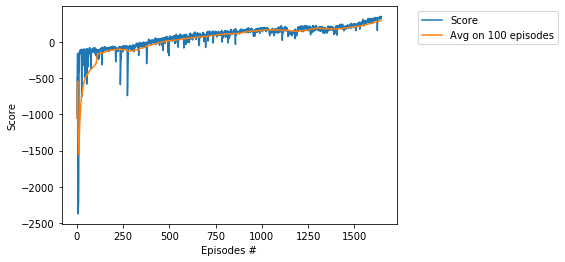

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [8]:
from envs import make_vec_envs

#--------------- make_vec_envs ----------------
## we continue with the same model, model Policy uses MLPBase, 
## but with single new environment env_venv

device = torch.device("cpu")
print('device: ', device)

seed = 0 
num_processes=1  

env_venv = make_vec_envs('BipedalWalker-v2', \
                    seed + 1000, num_processes,
                    None, None, False, device='cpu', allow_early_resets=False)

policy = policy.to(device)

print('env_venv.observation_space.shape: ', env_venv.observation_space.shape, \
      ', len(obs_shape): ', len(env_venv.observation_space.shape))
print('env_venv.action_space: ',  env_venv.action_space, \
      ', action_space.shape[0]: ', env_venv.action_space.shape[0])


device:  cpu
env_venv.observation_space.shape:  (24,) , len(obs_shape):  1
env_venv.action_space:  Box(4,) , action_space.shape[0]:  4


In [9]:
## No CUDA, only CPU

def play_VecEnv(env, model, num_episodes):

    obs = env.reset()
    obs = torch.Tensor(obs)
    obs = obs.float()
        
    recurrent_hidden_states = torch.zeros(1, model.recurrent_hidden_state_size)
    
    masks = torch.zeros(1, 1)
    
    scores_deque = deque(maxlen=100)

    render_func = get_render_func(env)
        
    for i_episode in range(1, num_episodes+1):     

        time_start = time.time()
        total_reward = np.zeros(num_processes)
        timestep = 0

        while True:
        
            with torch.no_grad():
                value, action, _, recurrent_hidden_states = \
                    model.act(obs, recurrent_hidden_states, masks, \
                    deterministic=False) # obs = state

            render_func()
            
            obs, reward, done, _ = env.step(action)
            obs = torch.Tensor(obs)
            obs = obs.float()

            reward = reward.detach().numpy()
            
            masks.fill_(0.0 if done else 1.0)
            
            total_reward += reward[0]
        
            timestep += 1
            
            if timestep + 1 == 1600: ##   envs.max_steps:
                break

        s = (int)(time.time() - time_start)
        
        scores_deque.append(total_reward[0])
        
        avg_score = np.mean(scores_deque)
                    
        print('Episode {} \tScore: {:.2f}, Avg.Score: {:.2f}, \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, total_reward[0], avg_score,  s//3600, s%3600//60, s%60))  


In [10]:
play_VecEnv(env=env_venv, model=policy, num_episodes=5)

Episode 1 	Score: 351.79, Avg.Score: 351.79, 	Time: 00:00:31
Episode 2 	Score: 366.75, Avg.Score: 359.27, 	Time: 00:00:27
Episode 3 	Score: 352.50, Avg.Score: 357.02, 	Time: 00:00:27
Episode 4 	Score: 381.94, Avg.Score: 363.25, 	Time: 00:00:27
Episode 5 	Score: 132.33, Avg.Score: 317.06, 	Time: 00:00:27


In [12]:
play_VecEnv(env=env_venv, model=policy, num_episodes=5)

Episode 1 	Score: 268.03, Avg.Score: 268.03, 	Time: 00:00:27
Episode 2 	Score: 357.58, Avg.Score: 312.81, 	Time: 00:00:27
Episode 3 	Score: 400.91, Avg.Score: 342.17, 	Time: 00:00:27
Episode 4 	Score: 364.58, Avg.Score: 347.78, 	Time: 00:00:27
Episode 5 	Score: 220.77, Avg.Score: 322.37, 	Time: 00:00:27


In [11]:
#env_venv.close()